In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_excel('test_task.xlsx')
df.head()

,Семестр,Форма обучения,Уровень,Оценка,Что повлияло на оценку
0,2,Очно-заочная,ВО,9,"Все ок, оценил справедливо"
1,6,Очная,СПО,7,Общение с проводником клуба (вопросы по путеше...
2,2,Очно-заочная,ВО,10,"Информационные брошюры клуба, Сетка мероприяти..."
3,1,Очно-заочная,ВО,10,Стоимость членства
4,7,Очно-заочная,ВО,10,Работа приложения клуба ABC


### EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8220 entries, 0 to 8219
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Семестр                 8220 non-null   int64 
 1   Форма обучения          8215 non-null   object
 2   Уровень                 8220 non-null   object
 3   Оценка                  8220 non-null   int64 
 4   Что повлияло на оценку  8220 non-null   object
dtypes: int64(2), object(3)
memory usage: 321.2+ KB


Из первичной информации видно, что 5 значений в форме обуучения не заполнены. Так как эти строки составляют маленькую часть данных, их можно удалить, но мы их постараемся заполнить

In [7]:
df[df['Форма обучения'].isnull()]

,Семестр,Форма обучения,Уровень,Оценка,Что повлияло на оценку
183,1,NaN,ВО,3,"Работа приложения клуба ABC, Общение с проводн..."
633,1,NaN,ВО,10,"Работа приложения клуба ABC, Общение с проводн..."
3288,1,NaN,ВО,10,"Работа приложения клуба ABC, Информационные бр..."
4310,1,NaN,ВО,10,"Работа приложения клуба ABC, Информационные бр..."
4733,1,NaN,ВО,10,"Работа приложения клуба ABC, Общение с проводн..."


У всех строк с незаполненным значением Форма образования общий признак в Уровне образования - ВО. Посмотрим какие значения принимает Форма образования при разных уровнях образования

In [8]:
# Уникальные Значения для столбца Форма обучения
df['Форма обучения'].unique()

array(['Очно-заочная', 'Очная', 'Заочная', nan], dtype=object)

In [9]:
# Количество уникальных значений для столбца Уровень
df['Уровень'].nunique()

4

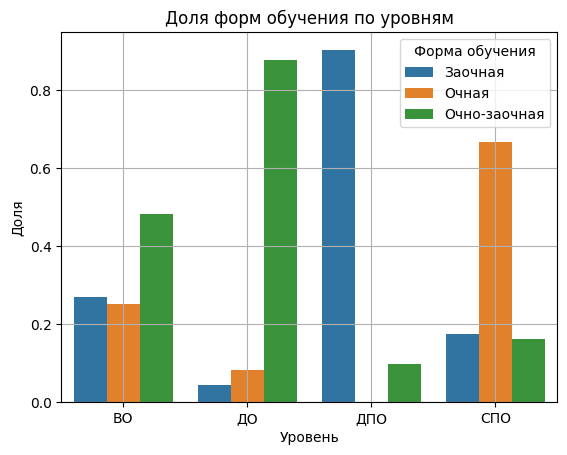

In [10]:
grouped_df = df.groupby(['Уровень', 'Форма обучения']).size().reset_index(name='count')

grouped_df['percentage'] = grouped_df['count'] / grouped_df.groupby('Уровень')['count'].transform('sum')


sns.barplot(x='Уровень', y='percentage', hue='Форма обучения', data=grouped_df)
plt.grid()
plt.xlabel('Уровень')
plt.ylabel('Доля')
plt.title('Доля форм обучения по уровням')
plt.show()

Из графика видно, что в 50% случаев в Уровне ВО Очно-заочная форма образования. Так мы и заполним отсутствующие 5 значений

In [11]:
df['Форма обучения'] = df['Форма обучения'].fillna('Очно-заочная')

Посмотрим на распределения числовых значений

array([[<Axes: title={'center': 'Семестр'}>,
        <Axes: title={'center': 'Оценка'}>]], dtype=object)

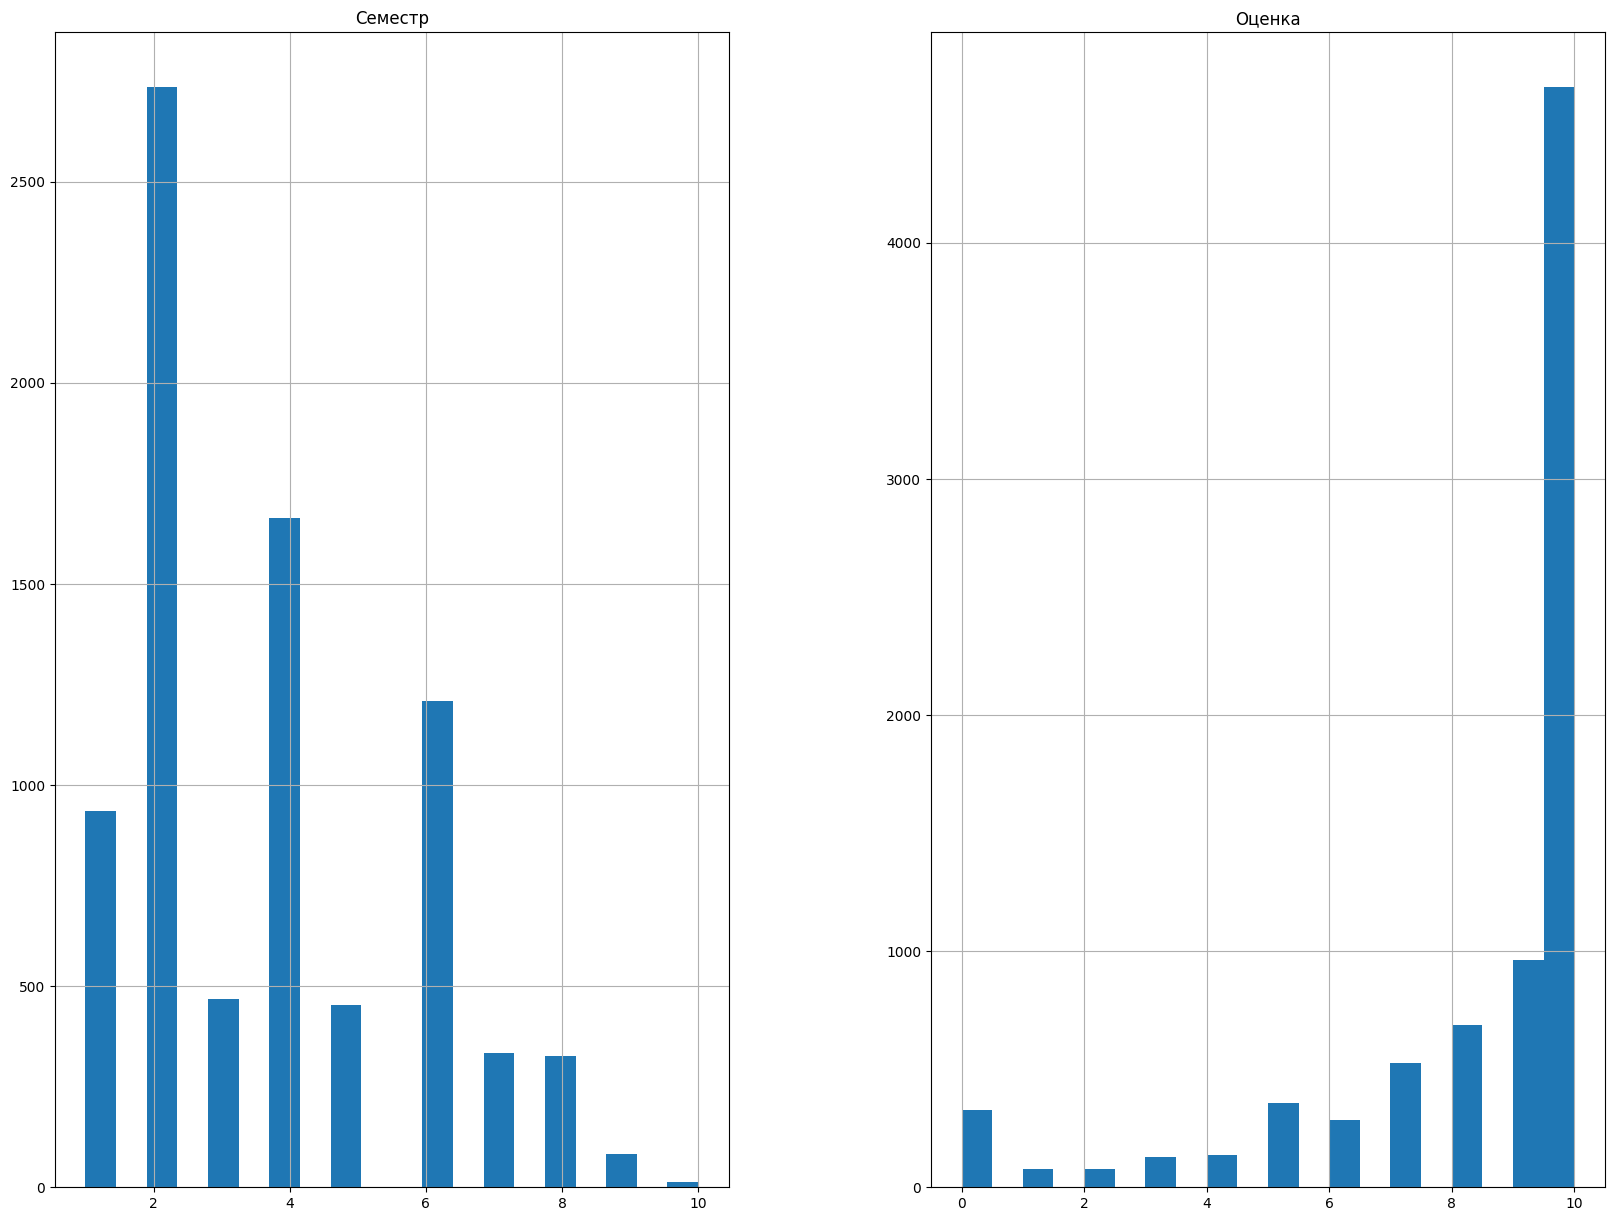

In [12]:
df.hist(bins=20, figsize=(20, 15))

Из распределения оценок можно сделать вывод что студенты в большинстве довольны работой клуба путешественников. Распределение данных по семестрам показывает интересную зависимость, под конец учебного года студенты более активно вступают в клуб. Основной интерес проявляют студенты младших курсов, включая 3-ий. 4 и 5 курс, готовятся к выпускным экзаминам, больше погружаются во взрослую жизнь. При обученни модели семестр может играть важную роль. Поделим наши оценки на три класса и построим графики зависимостей классов от Уровня образования, Формы образования, и Семестра

In [13]:
def grade_to_level(grade):
    if grade >= 8: return 'Доволен'
    elif grade >= 5: return 'Средне'
    else:
        return 'Недоволен'

In [14]:
df['target_level'] = df['Оценка'].apply(grade_to_level)

In [15]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['target_level'])

In [16]:
le.classes_

array(['Доволен', 'Недоволен', 'Средне'], dtype=object)

Text(0.5, 1.0, 'Удовлетворенность клубом по форме обучения')

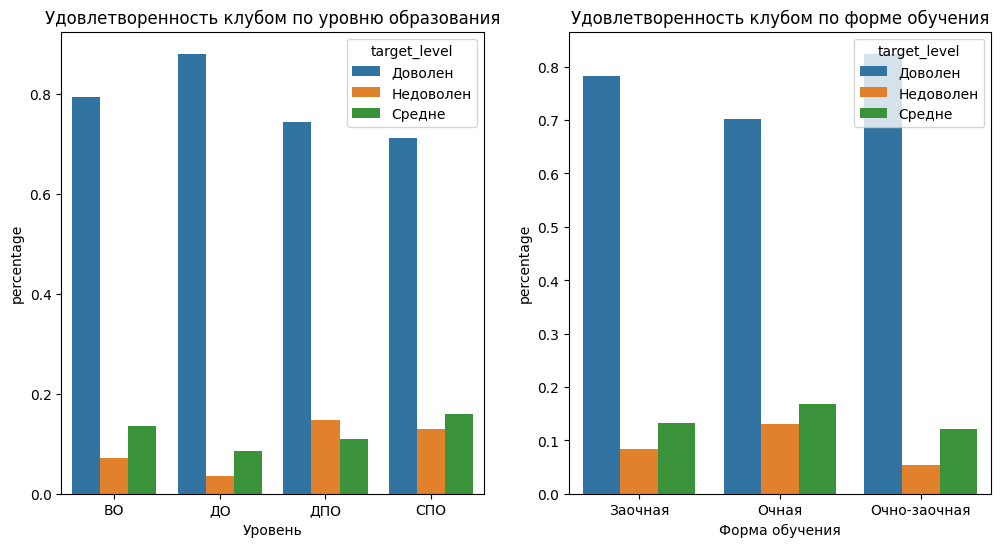

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

grouped_level = df.groupby(['Уровень', 'target_level']).size().reset_index(name='count')
grouped_level['percentage'] = grouped_level['count'] / grouped_level.groupby('Уровень')['count'].transform('sum')
sns.barplot(x='Уровень', y='percentage', hue='target_level', data=grouped_level, ax=axs[0])
axs[0].set_title('Удовлетворенность клубом по уровню образования')

grouped_form = df.groupby(['Форма обучения', 'target_level']).size().reset_index(name='count')
grouped_form['percentage'] = grouped_form['count'] / grouped_form.groupby('Форма обучения')['count'].transform('sum')
sns.barplot(x='Форма обучения', y='percentage', hue='target_level', data=grouped_form, ax=axs[1])
axs[1].set_title('Удовлетворенность клубом по форме обучения')



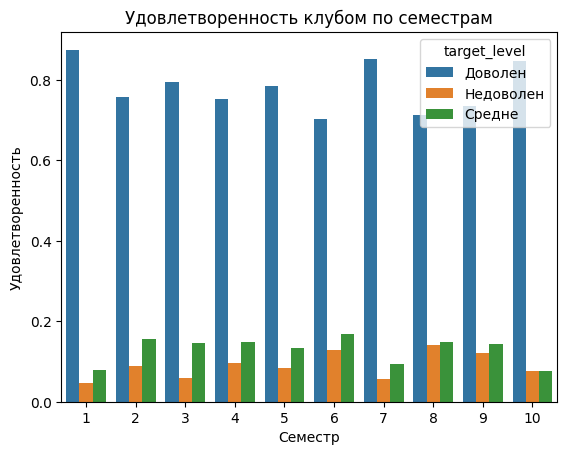

In [18]:
grouped_semester = df.groupby(['Семестр', 'target_level']).size().reset_index(name='count')

grouped_semester['percentage'] = grouped_semester['count'] / grouped_semester.groupby('Семестр')['count'].transform('sum')


sns.barplot(x='Семестр', y='percentage', hue='target_level', data=grouped_semester)
plt.xlabel('Семестр')
plt.ylabel('Удовлетворенность')
plt.title('Удовлетворенность клубом по семестрам')
plt.show()

Распределение значений примерно одинаковое, особых зависимостей нет.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8220 entries, 0 to 8219
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Семестр                 8220 non-null   int64 
 1   Форма обучения          8220 non-null   object
 2   Уровень                 8220 non-null   object
 3   Оценка                  8220 non-null   int64 
 4   Что повлияло на оценку  8220 non-null   object
 5   target_level            8220 non-null   object
 6   label                   8220 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 449.7+ KB


Разделим колонку "Что повлияло на оценку" так, чтобы каждый ответ стал отдельной колонкой и на выходе получился вектор One Hot Encoding

In [20]:
all_answers = set()
for answers in df['Что повлияло на оценку']:
    answers_list = re.findall(r'[А-Я][^,]*', answers)
    all_answers.update(answers_list)

print(f'Количество уникальных ответов {len(all_answers)}')

Количество уникальных ответов 19


In [21]:
all_answers

{'Все ок',
 'Далеко здание клуба',
 'Еда в клубе',
 'Игнор по заданным вопросам',
 'Информационные брошюры клуба',
 'Мало путешествий/сборов',
 'Место временного пребывания',
 'Не нравятся участники клуба',
 'Не ту кнопку нажал/не подумал',
 'Общение с персональным наставником клуба ABC',
 'Общение с проводником клуба (вопросы по путешествиям)',
 'Проводники',
 'Работа приложения клуба ABC',
 'Ремонт в клубе',
 'Сетка мероприятий',
 'Стоимость членства',
 'Фан-встречи',
 'Часто звонят',
 'Членское удостоверение'}

In [22]:
# Создадим новые колонки и заполним их сначала 0, потом проитерируемся по колонке, что повлияло на оценку и заполним единичками там где есть пересечения
for answer in all_answers:
    df[answer] = 0

for index, row in df.iterrows():
    answers = re.findall(r'[А-Я][^,]*', row['Что повлияло на оценку'])
    for answer in answers:
        df.at[index, answer] = 1


df = df.drop(columns=['Что повлияло на оценку', 'Оценка', 'target_level'])

df.head(10)

,Семестр,Форма обучения,Уровень,label,Не нравятся участники клуба,Стоимость членства,Членское удостоверение,Общение с персональным наставником клуба ABC,Далеко здание клуба,Проводники,...,Работа приложения клуба ABC,Ремонт в клубе,Сетка мероприятий,Все ок,Мало путешествий/сборов,Часто звонят,Не ту кнопку нажал/не подумал,Еда в клубе,Фан-встречи,Общение с проводником клуба (вопросы по путешествиям)
0,2,Очно-заочная,ВО,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,6,Очная,СПО,2,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
2,2,Очно-заочная,ВО,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
3,1,Очно-заочная,ВО,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,Очно-заочная,ВО,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,7,Заочная,ВО,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,4,Очно-заочная,ВО,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
7,4,Заочная,СПО,0,0,0,0,1,0,1,...,1,1,1,1,0,0,0,0,0,1
8,2,Очно-заочная,ВО,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,6,Очная,ВО,2,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,1


Построим корреляционную матрицу для датафрейма, включая отображение категориальных переменных. Для их отображения будем использовать метод Крамера.

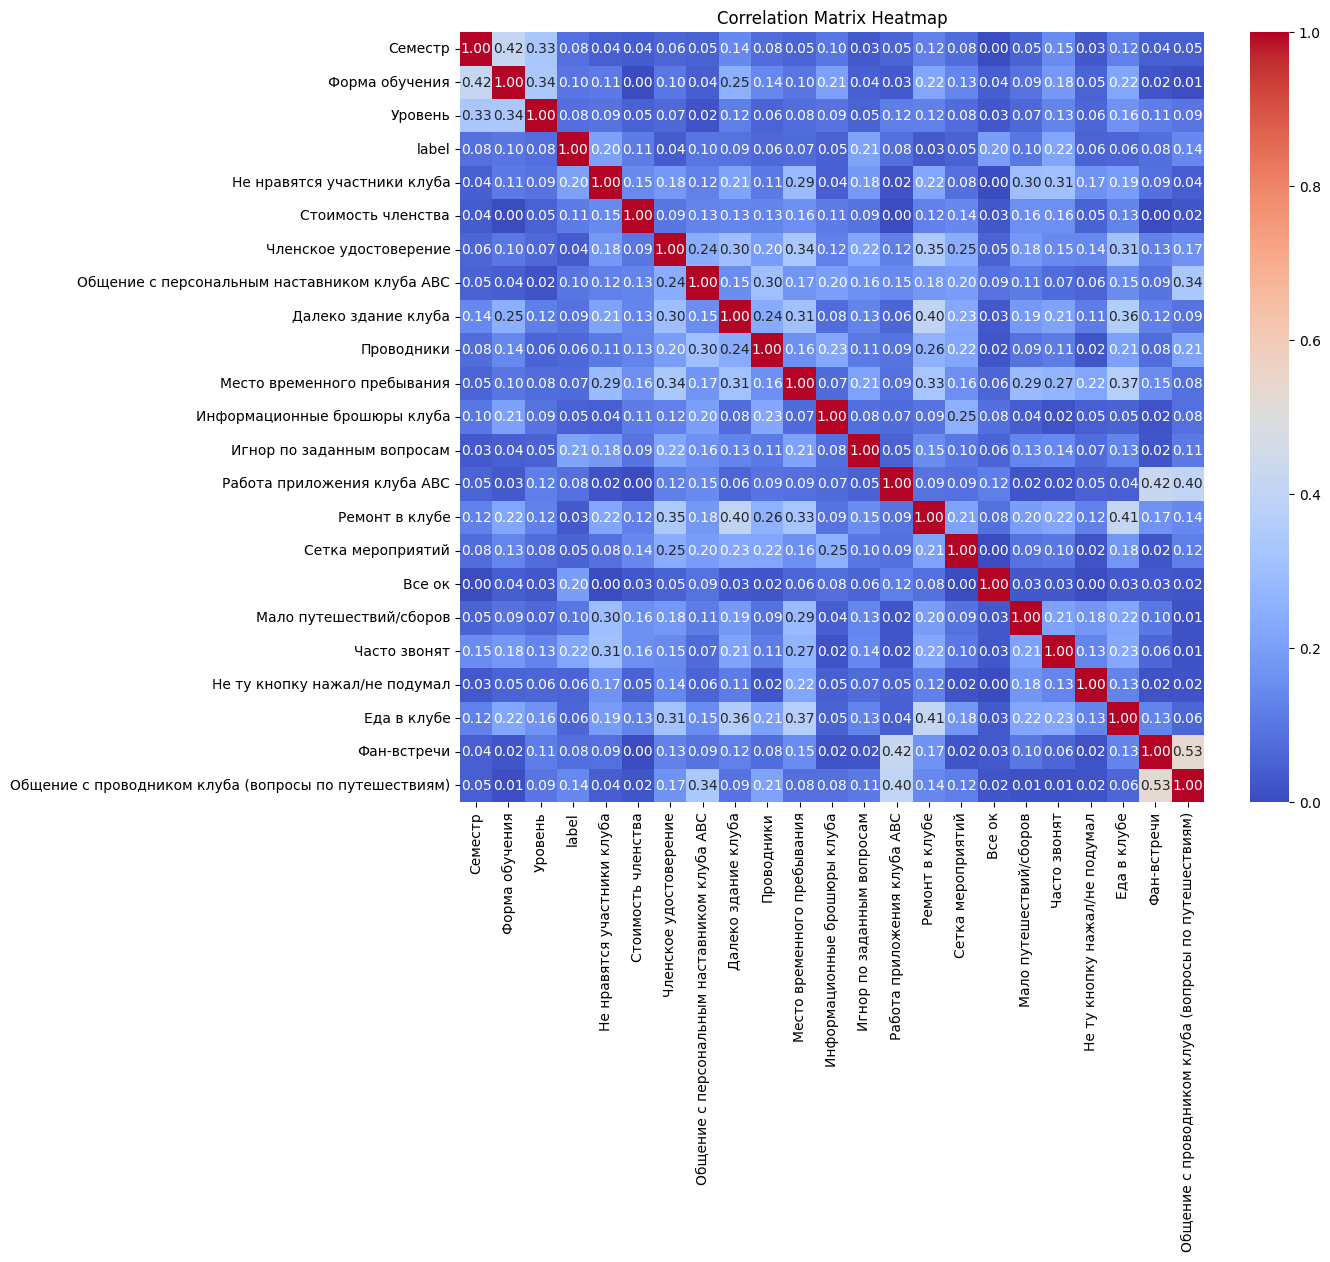

In [23]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Создание корреляционной матрицы для всех переменных в датафрейме
correlation_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
for i in df.columns:
    for j in df.columns:
        correlation_matrix.loc[i, j] = cramers_v(df[i], df[j])

# Преобразование значений в числовой формат для построения heatmap
correlation_matrix = correlation_matrix.apply(pd.to_numeric)

# Создание heatmap с использованием seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

Из корреляционной матрицы видно, что признаки слабо коррелируют с целевой переменной label, поэтому будем использовать алгоритмы градиентного бустинга, чтобы получить хороший результат. Также видно, что есть признаки которые достаточно сильно коррелируют друг с другом. Удалим из обучающего датасета следующие признааки:
- Форма обучения
- Уровень
- Фан-встречи
- Ремонт в клубе.
Это признаки, которые имеют большую корреляцию друг с другом и слабо влияют на целевую переменную. В результате модель может отвлекаться на эти признаки и показывать недостаточно хороший результат на обучении целевой переменной.


### Подготовка данных для обучения

In [24]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import joblib

In [25]:
df.columns

Index(['Семестр', 'Форма обучения', 'Уровень', 'label',
       'Не нравятся участники клуба', 'Стоимость членства',
       'Членское удостоверение',
       'Общение с персональным наставником клуба ABC', 'Далеко здание клуба',
       'Проводники', 'Место временного пребывания',
       'Информационные брошюры клуба', 'Игнор по заданным вопросам',
       'Работа приложения клуба ABC', 'Ремонт в клубе', 'Сетка мероприятий',
       'Все ок', 'Мало путешествий/сборов', 'Часто звонят',
       'Не ту кнопку нажал/не подумал', 'Еда в клубе', 'Фан-встречи',
       'Общение с проводником клуба (вопросы по путешествиям)'],
      dtype='object')

In [26]:
X = pd.get_dummies(df.drop(columns=['Форма обучения', 'Уровень', 'Фан-встречи', 'Ремонт в клубе','label']))

In [27]:
y = df['label']

In [28]:
#Проверим баланс классов на тренировочной и тестовой выборке
train_class_counts = y.value_counts()
print("Баланс классов:")
print(train_class_counts)

Баланс классов:
label
0    6308
2    1169
1     743
Name: count, dtype: int64


Видим сильный дисбаланс классов, будем балансировать классы

### Начнем обучение с простых моделей и постеепенно будем усложнять алгоритмы

In [29]:
def get_score(X,y, random_seed=100, model=None, depth=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    if model is None:
        model = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred)
    if model == 'Random_Forest':
        if depth is None:
            model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=400, class_weight='balanced', random_state=random_seed, max_depth=3))
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred)
        else:
            model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=400, class_weight='balanced', random_state=random_seed, max_depth=depth))
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred)
    if model == 'Decision_Tree':
        if depth is None:
            model = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=3, class_weight='balanced'))
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred)
        else:
            model = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=depth, class_weight='balanced'))
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred)
    if model == 'Bagging':
        if depth is None:
            model = make_pipeline(StandardScaler(), BaggingClassifier(DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
                                    n_estimators=10,
                                    max_samples=0.5,
                                    max_features=0.5,
                                    random_state=10))
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred)
        else:
            model = make_pipeline(StandardScaler(), BaggingClassifier(DecisionTreeClassifier(max_depth=depth, class_weight='balanced'),
                                    n_estimators=10,
                                    max_samples=0.5,
                                    max_features=0.5,
                                    random_state=10))
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred)
    if model == 'SVC':
        model = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=random_seed, class_weight='balanced'))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred)

In [30]:
Log_reg, report= get_score(X, y)

print(report)


              precision    recall  f1-score   support

           0       0.91      0.59      0.71      1910
           1       0.25      0.60      0.35       201
           2       0.21      0.44      0.28       355

    accuracy                           0.57      2466
   macro avg       0.46      0.54      0.45      2466
weighted avg       0.75      0.57      0.62      2466



Определим оптимальную глубину для случайного леса

In [31]:
list_depth = [3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for i in list_depth:
    res, report = get_score(X,y, model = 'Random_Forest', depth=i)
    print(str(i)+'____'+str(res))

3____0.532441200324412
4____0.5356853203568532
5____0.5397404703974047
7____0.5628548256285483
8____0.5677210056772101
9____0.5681265206812652
10____0.5774533657745337
11____0.5811030008110301
12____0.5936739659367397
13____0.6034063260340633
14____0.6074614760746148
15____0.6013787510137875
16____0.597323600973236
17____0.5948905109489051
18____0.5896188158961881
19____0.592051905920519
20____0.5940794809407948


In [32]:
Random_forest, report = get_score(X, y, model = 'Random_Forest', depth=14)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.68      0.76      1910
           1       0.24      0.31      0.27       201
           2       0.20      0.40      0.27       355

    accuracy                           0.61      2466
   macro avg       0.44      0.46      0.43      2466
weighted avg       0.71      0.61      0.65      2466



Определим оптимальную глубину для дерева решений

In [33]:
list_depth = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
for i in list_depth:
    res,_ = get_score(X,y, model = 'Decision_Tree', depth=i)
    print(str(i)+'____'+str(res))

5____0.5235198702351987
10____0.5072992700729927
15____0.5263584752635847
20____0.5482562854825629
25____0.5494728304947283
30____0.5482562854825629
35____0.5478507704785077
40____0.5486618004866181
45____0.5506893755068938
50____0.5482562854825629
55____0.5478507704785077
60____0.5482562854825629
65____0.5494728304947283
70____0.5502838605028386
75____0.551094890510949
80____0.5474452554744526
85____0.5494728304947283
90____0.5502838605028386
95____0.5494728304947283
100____0.5482562854825629


In [34]:
Decision_Tree, report = get_score(X, y, model = 'Decision_Tree', depth=57)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.61      0.71      1910
           1       0.14      0.27      0.19       201
           2       0.18      0.36      0.24       355

    accuracy                           0.55      2466
   macro avg       0.39      0.41      0.38      2466
weighted avg       0.70      0.55      0.60      2466



Определим оптимальную глубину деревьев для Бегинга

In [35]:
list_depth = [3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for i in list_depth:
    res,_ = get_score(X,y, model = 'Bagging', depth=i)
    print(str(i)+'____'+str(res))

3____0.5660989456609895
4____0.5742092457420924
5____0.5774533657745337
7____0.6082725060827251
8____0.6147607461476075
9____0.6070559610705596
10____0.6167883211678832
11____0.6098945660989457
12____0.615977291159773
13____0.6184103811841039
14____0.6155717761557178
15____0.615977291159773
16____0.615977291159773
17____0.615977291159773
18____0.615977291159773
19____0.615977291159773
20____0.615977291159773


In [36]:
Bagging, report = get_score(X, y, model = 'Bagging', depth=15)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.69      0.76      1910
           1       0.23      0.31      0.27       201
           2       0.21      0.40      0.28       355

    accuracy                           0.62      2466
   macro avg       0.44      0.47      0.44      2466
weighted avg       0.72      0.62      0.65      2466



In [37]:
SVC_model, report = get_score(X, y, model = 'SVC')
print(report)

              precision    recall  f1-score   support

           0       0.91      0.53      0.67      1910
           1       0.24      0.53      0.33       201
           2       0.18      0.47      0.26       355

    accuracy                           0.52      2466
   macro avg       0.44      0.51      0.42      2466
weighted avg       0.75      0.52      0.59      2466



In [38]:
data = [Log_reg, Random_forest, Decision_Tree, Bagging, SVC_model]
columns = ['Log_reg', 'Random_forest', 'Decision_Tree', 'Bagging', 'SVC_model']
results = pd.DataFrame(data=data, index=columns)

results

,0
Log_reg,0.567315
Random_forest,0.607461
Decision_Tree,0.546229
Bagging,0.615977
SVC_model,0.523114


Попробуем обучить алгоритм Стэкингга из уже опробованных моделей

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [40]:
estimators = [
        ('DecisionTreeClassifier',make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=5, class_weight='balanced'))),
        ('RandomForestClassifier',make_pipeline(StandardScaler(),RandomForestClassifier(max_depth=3,class_weight='balanced'))),
        ('LinearSVC', make_pipeline(StandardScaler(), SVC(class_weight='balanced')))
        ]
Regressor = StackingClassifier(estimators=estimators)

In [41]:
Regressor.fit(X_train,y_train)

StackingClassifier(estimators=[('DecisionTreeClassifier',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('decisiontreeclassifier',
                                                 DecisionTreeClassifier(class_weight='balanced',
                                                                        max_depth=5))])),
                               ('RandomForestClassifier',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier(class_weight='balanced',
                                                                        max_depth=3))])),
                               ('LinearSVC',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('svc',
                                                 SVC(class_weight='balanced'))]))])

In [42]:
y_pred = Regressor.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7798053527980535


In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1910
           1       0.57      0.08      0.14       201
           2       0.00      0.00      0.00       355

    accuracy                           0.78      2466
   macro avg       0.45      0.36      0.34      2466
weighted avg       0.65      0.78      0.69      2466



Стеккинг переучивается в сторону большего класса.

In [44]:
results.loc['Stacking'] = accuracy
results

,0
Log_reg,0.567315
Random_forest,0.607461
Decision_Tree,0.546229
Bagging,0.615977
SVC_model,0.523114
Stacking,0.779805


Попробуем обучить алгоритм Градиентного Бустинга. Будем сразу определять лучшие параметры с помощью метода GridSearchCV

In [45]:
# Вычислим веса для каждого класса для балансировки Градиентного Бустинга
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [46]:
def find_optimal_params(X_train, y_train):
    # Определение сетки параметров для поиска
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    # Создание модели
    gbc = GradientBoostingClassifier(random_state=42)

    # Создание объекта GridSearchCV
    grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

    # Обучение модели с поиском по сетке параметров
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)

    # Возвращение оптимальных параметров
    return grid_search.best_params_

In [47]:
optimal_params = find_optimal_params(X_train, y_train)
print(optimal_params)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.0s[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   0.0s

[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END le

In [48]:
optimal_params

{'learning_rate': 0.1,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200,
 'subsample': 0.8}

In [49]:
gbc = GradientBoostingClassifier(**optimal_params)
gbc.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = gbc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5916463909164639


In [50]:
results.loc['GradBoost'] = accuracy
results

,0
Log_reg,0.567315
Random_forest,0.607461
Decision_Tree,0.546229
Bagging,0.615977
SVC_model,0.523114
Stacking,0.779805
GradBoost,0.591646


In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.63      0.74      1910
           1       0.24      0.54      0.33       201
           2       0.21      0.40      0.27       355

    accuracy                           0.59      2466
   macro avg       0.45      0.52      0.45      2466
weighted avg       0.75      0.59      0.64      2466



Из classification_report можно отдать предпочтение либо Логистической регрессии либо Градиентному бустингу. У этих моделей более сбалансированно предсказываются все три класса.

### Попробуем обработать колонку "Что повлияло на оценку с помощью Tfidf векторайзера

In [52]:
df = pd.read_excel('test_task.xlsx')
df.head()

,Семестр,Форма обучения,Уровень,Оценка,Что повлияло на оценку
0,2,Очно-заочная,ВО,9,"Все ок, оценил справедливо"
1,6,Очная,СПО,7,Общение с проводником клуба (вопросы по путеше...
2,2,Очно-заочная,ВО,10,"Информационные брошюры клуба, Сетка мероприяти..."
3,1,Очно-заочная,ВО,10,Стоимость членства
4,7,Очно-заочная,ВО,10,Работа приложения клуба ABC


In [53]:
df['Форма обучения'] = df['Форма обучения'].fillna('Очно-заочная')

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

In [56]:
nltk.download('stopwords')
russian_stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vyacheslav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
df['Что повлияло на оценку'] = df['Что повлияло на оценку'].str.lower()

In [58]:
vectorizer = TfidfVectorizer(stop_words=russian_stop_words)

In [59]:
X_tfidf = vectorizer.fit_transform(df['Что повлияло на оценку'])

In [60]:
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
df_tfidf.head()

,abc,брошюры,вопросам,вопросы,временного,встречи,далеко,еда,заданным,звонят,...,сетка,справедливо,стоимость,ту,удостоверение,участники,фан,часто,членское,членства
0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.577350,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.000000,0.000000,0.0,0.23213,0.0,0.0,0.0,0.0,0.0,0.422865,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.422865,0.0,0.000000
2,0.000000,0.288787,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.376024,0.345327,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.707107,0.0,0.0,0.0,0.0,0.000000,0.0,0.707107
4,0.513107,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [61]:
def grade_to_level(grade):
    if grade >= 8: return 'Доволен'
    elif grade >= 5: return 'Средне'
    else:
        return 'Недоволен'

In [62]:
df['target_level'] = df['Оценка'].apply(grade_to_level)

In [63]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['target_level'])

In [64]:
le.classes_

array(['Доволен', 'Недоволен', 'Средне'], dtype=object)

In [65]:
X = df_tfidf.join(df['Семестр'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Обучим Логистическую регрессию и Градиентный бустинг, чтобы сравнить результаты с предыдущим алгоритмом обработки датасета

In [66]:

clf = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy test:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy test: 0.5462287104622872
              precision    recall  f1-score   support

           0       0.89      0.59      0.71      1252
           1       0.22      0.53      0.31       150
           2       0.18      0.33      0.23       242

    accuracy                           0.55      1644
   macro avg       0.43      0.48      0.42      1644
weighted avg       0.72      0.55      0.60      1644



In [67]:
# Вычислим веса для каждого класса для балансировки Градиентного Бустинга
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [68]:

def find_optimal_params(X_train, y_train):
    # Определение сетки параметров для поиска
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    # Создание модели
    gbc = GradientBoostingClassifier(random_state=42)

    # Создание объекта GridSearchCV
    grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

    # Обучение модели с поиском по сетке параметров
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)

    # Возвращение оптимальных параметров
    return grid_search.best_params_

In [69]:
optimal_params = find_optimal_params(X_train, y_train)
print(optimal_params)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END le

In [70]:
optimal_params

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'subsample': 1.0}

In [71]:
gbc = GradientBoostingClassifier(**optimal_params)
gbc.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = gbc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5602189781021898


In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.63      0.73      1252
           1       0.21      0.37      0.27       150
           2       0.16      0.30      0.21       242

    accuracy                           0.56      1644
   macro avg       0.41      0.43      0.40      1644
weighted avg       0.69      0.56      0.61      1644



XGboost

In [79]:
from imblearn.over_sampling import SMOTE

In [80]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=3)

In [81]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

In [82]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [83]:
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train_res, y_train_res)

best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}


In [84]:
best_xgb_clf = grid_search.best_estimator_
best_xgb_clf.fit(X_train_res, y_train_res)
y_pred = best_xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5575831305758313


In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1910
           1       0.20      0.40      0.26       201
           2       0.19      0.40      0.26       355

    accuracy                           0.56      2466
   macro avg       0.42      0.47      0.41      2466
weighted avg       0.71      0.56      0.61      2466



# Вывод
По результатам поиска оптимальной предобработки и алгоритма обучения, склоняюсь к первому варианту предобработки, тк результаты получаются выше чем при варианте векторизации. Алгоритм обучения выбираем GradientBoostingClassifier, так как он показывает лучшую полноту (recall) определения классов.

### Компактный код предобработки и сохранения весов модели

In [87]:
df = pd.read_excel('test_task.xlsx')
df['Форма обучения'] = df['Форма обучения'].fillna('Очно-заочная')
df['target_level'] = df['Оценка'].apply(grade_to_level)

le = LabelEncoder()
df['label'] = le.fit_transform(df['target_level'])

all_answers = set()
for answers in df['Что повлияло на оценку']:
    answers_list = re.findall(r'[А-Я][^,]*', answers)
    all_answers.update(answers_list)

for answer in all_answers:
    df[answer] = 0

for index, row in df.iterrows():
    answers = re.findall(r'[А-Я][^,]*', row['Что повлияло на оценку'])
    for answer in answers:
        df.at[index, answer] = 1


df = df.drop(columns=['Что повлияло на оценку', 'Оценка', 'target_level', 'Форма обучения', 'Уровень', 'Фан-встречи', 'Ремонт в клубе'])

In [88]:
X = pd.get_dummies(df.drop(columns=['label']))
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

gbc = GradientBoostingClassifier(**{'learning_rate': 0.1,
                                    'max_depth': 5,
                                    'max_features': 'sqrt',
                                    'min_samples_leaf': 1,
                                    'min_samples_split': 5,
                                    'n_estimators': 100,
                                    'subsample': 0.8})
gbc.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = gbc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Accuracy: 0.583536090835361
              precision    recall  f1-score   support

           0       0.90      0.63      0.74      1910
           1       0.23      0.49      0.31       201
           2       0.20      0.40      0.27       355

    accuracy                           0.58      2466
   macro avg       0.44      0.51      0.44      2466
weighted avg       0.75      0.58      0.64      2466



In [89]:
joblib.dump(gbc, 'gradient_boosting_model.pkl')

['gradient_boosting_model.pkl']

### Код для инференса

In [90]:
def grade_to_level(grade):
    if grade >= 8: return 'Доволен'
    elif grade >= 5: return 'Средне'
    else:
        return 'Недоволен'

def predict_grade(data):
    model = joblib.load('gradient_boosting_model.pkl')
    df = pd.DataFrame(data)
    df['target_level'] = df['Оценка'].apply(grade_to_level)

    le = LabelEncoder()
    df['label'] = le.fit_transform(df['target_level'])

    all_answers = set()
    for answers in df['Что повлияло на оценку']:
        answers_list = re.findall(r'[А-Я][^,]*', answers)
        all_answers.update(answers_list)

    for answer in all_answers:
        df[answer] = 0

    for index, row in df.iterrows():
        answers = re.findall(r'[А-Я][^,]*', row['Что повлияло на оценку'])
        for answer in answers:
            df.at[index, answer] = 1


    df = df.drop(columns=['Что повлияло на оценку', 'Оценка', 'target_level', 'Форма обучения', 'Уровень', 'Фан-встречи', 'Ремонт в клубе'])

    # Убедитесь, что порядок и количество столбцов в новых данных соответствует обучающим данным
    required_columns = model.feature_names_in_
    for col in required_columns:
        if col not in df.columns:
            df[col] = 0
    df = df[required_columns]

    # Предсказания на новых данных
    predictions = model.predict(df)

    # Добавление предсказаний в датафрейм
    df['predictions'] = predictions

    # Преобразование предсказаний обратно в исходные метки (если нужно)
    df['predicted_level'] = le.inverse_transform(df['predictions'])

    # Сохранение результатов в новый Excel файл
    df.to_excel('predictions.xlsx', index=False)
